In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from pettingzoo.classic import go_v5
from SMPyBandits import Policies
from torch.utils.tensorboard import SummaryWriter
import warnings
import torch
from torch import nn
import torch.nn.functional as F
import random
import itertools

If you want the speed up brought by numba.jit, try to manually install numba and check that it works (installing llvmlite can be tricky, cf. https://github.com/numba/numba#custom-python-environments
Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...
If you want the speed up brought by numba.jit, try to manually install numba and check that it works (installing llvmlite can be tricky, cf. https://github.com/numba/numba#custom-python-environments


In [2]:
def fixedMOSSEcomputeAllIndex(self):
    """ Compute the current indexes for all arms, in a vectorized manner."""
    pulls_of_suboptimal_arms = np.sum(self.pulls[self.pulls < np.sqrt(self.t)])
    if pulls_of_suboptimal_arms > 0:
        indexes = (self.rewards / self.pulls) + np.sqrt(0.5 * np.maximum(0, np.log(self.t / pulls_of_suboptimal_arms)) / self.pulls)
    else:
        indexes = (self.rewards / self.pulls) + np.sqrt(0.5 * np.maximum(0, np.log(self.t / (self.nbArms * self.pulls))) / self.pulls)
    # indexes[self.pulls < 1] = float('+inf')
    self.index[:] = indexes
Policies.MOSSExperimental.computeAllIndex = fixedMOSSEcomputeAllIndex

Simple Multi-Armed Bandit

In [13]:
# meta_policy = Policies.UCB(len(policy_algorithm_list))
# squares = np.zeros(len(policy_algorithm_list))
while True:
    # meta_choice = meta_policy.choice()
    meta_choice = np.argmin(meta_policy.pulls)
    print(f'choice:{meta_choice}')
    policy_algorithm = policy_algorithm_list[meta_choice]
    num_arms = 10
    num_fictitious_pulls = 1000
    random_fictitious = False
    if random_fictitious:
        fictitious_pulls = np.random.dirichlet(num_arms*[1])*num_fictitious_pulls
        fictitious_empirical_means = np.random.random(num_arms)
    else:
        fictitious_pulls = np.array(num_arms*[0])
        fictitious_empirical_means = np.array(num_arms*[0])

    # print(fictitious_pulls)

    fictitious_rewards = fictitious_pulls * fictitious_empirical_means
    # print(fictitious_rewards)
    # policy = Policies.UCBoost_bq_h_lb(num_arms)
    policy = policy_algorithm(num_arms)
    # policy = CPUCB(num_arms)
    # policy = klUCB(num_arms)
    policy.pulls = fictitious_pulls
    # print(policy.pulls)
    policy.rewards = fictitious_rewards
    # true_probs = np.random.random(num_arms)
    # true_probs = np.array([.5]* num_arms)
    true_probs = scipy.stats.beta.rvs(50,50,size=num_arms)
    # print(true_probs)

    for i in range(10000):
        # print(policy.index)
        action = policy.choice()
        reward = np.random.binomial(1,true_probs[action])
        policy.getReward(action, reward)
        # policy.pulls[action]+=1
        # policy.rewards[action]+=reward
        # print(action,reward)
        # print(policy.pulls)
        # policy.computeAllIndex()
    # print(true_probs)
    # print(true_probs.round(4))
    print('pulls:')
    print(policy.pulls)
    print('rewards:')
    print(policy.rewards)
    # print(policy.rewards/policy.pulls)
    regret = policy.pulls.sum()*true_probs.max()-(policy.pulls*true_probs).sum()
    print(f'regret:{regret}')
    meta_policy.getReward(meta_choice, -regret)
    squares[meta_choice]+=regret**2
    print('meta mean rewards')
    print(meta_policy.rewards/(meta_policy.pulls+.0001))
    print('meta pulls:')
    score = -meta_policy.rewards/(meta_policy.pulls+.0001)
    stdev = np.sqrt(squares/(meta_policy.pulls+.0001)-score**2)
    mean_stdev = stdev/np.sqrt((meta_policy.pulls+.0001))
    print((pd.DataFrame({'Name':policy_algorithm_names, 'score': score, 'mean stdev': mean_stdev, 'stdev': stdev, 'pulls': meta_policy.pulls})).sort_values(by='score'))

NameError: name 'meta_policy' is not defined

In [ ]:
policy_algorithm_list = [Policies.ProbabilityPursuit, Policies.EmpiricalMeans, Policies.UCB, Policies.UCBmin, Policies.UCBplus, Policies.UCBVtuned, Policies.MOSS, Policies.MOSSAnytime, Policies.MOSSExperimental, Policies.klUCB, Policies.klUCBloglog, Policies.klUCBPlus, Policies.klUCBswitchAnytime, Policies.DMED, Policies.DMEDPlus, Policies.AdBandits, Policies.LM_DSEE, Policies.BESA]

In [ ]:
policy_algorithm_names = ['ProbabilityPursuit', 'EmpiricalMeans', 'UCB', 'UCBmin', 'UCBplus', 'UCBVtuned', 'MOSS', 'MOSSAnytime', 'MOSSExperimental', 'klUCB', 'klUCBloglog', 'klUCBPlus', 'klUCBswitchAnytime', 'DMED', 'DMEDPlus', 'AdBandits', 'LM_DSEE', 'BESA']

In [ ]:
(pd.DataFrame({'Name':policy_algorithm_names, 'score': -meta_policy.rewards/(meta_policy.pulls+.0001), 'pulls': meta_policy.pulls})).sort_values(by='score')

In [ ]:
benchmark(policy_algorithm_list[0])

In [ ]:
results = []
for i in range(len(policy_algorithm_list)):
    try:
        results.append(benchmark(policy_algorithm_list[i]))
    except:
        results.append(f'fail:{i}')

Multi-Armed Bandit Trees

Synthetically-Generated Tree-based Games

In [3]:
class Node():
    def __init__(self, mean, game_length, depth, num_arms):
        self.mean = mean
        self.game_length = game_length
        self.depth = depth
        self.num_arms = num_arms
        self.policy = klUCBPlus(num_arms)
        self.fictitious_pulls = np.array(num_arms*[1])
        self.fictitious_rewards = np.array(num_arms*[0])
        self.policy.pulls = self.fictitious_pulls.copy()
        self.policy.rewards = self.fictitious_rewards.copy()
        if game_length == depth:
            self.action_means = scipy.stats.bernoulli.rvs(self.mean, size=num_arms)
        else:
            self.action_means = scipy.stats.beta.rvs(self.mean*9+.001,(1-self.mean)*9+.001,size=num_arms)
            # self.action_means = self.action_means*self.mean/self.action_means.mean()
        self.next_nodes = {}

In [ ]:
size = 25
root_node = Node(mean=.5, game_length = size, depth = 1, num_arms = size)
writer = SummaryWriter()
reward_list = []
big_number = 1e10
win_condition = 100
i = 0
while True:
    node=root_node
    node_action_list = []
    while True:
        action = node.policy.choice()
        node_action_list.append((node,action))
        if node.depth == node.game_length:
            reward = node.action_means[action]
            writer.add_scalar('Reward', reward, str(i))
            reward_list.append(reward)
            break
        else:
            node = node.next_nodes.setdefault(action, Node(mean=node.action_means[action], game_length=node.game_length, depth=node.depth+1, num_arms=node.num_arms))
    node_solved = False
    for node, action in reversed(node_action_list):
        if node_solved !=0:
            node.policy.pulls[action] = -node_solved * big_number
            node.fictitious_rewards[action] 
            node.policy.pulls[action] +=1
        else:
            node.policy.getReward(action, (reward if node.depth%2 else 1-reward))
        node_solved = 1 if any((node.policy.rewards==big_number)==(node.policy.pulls==big_number)) else (-1 if all(node.policy.rewards==-big_number) else 0)
    if node_action_list[-1][0].depth % 2 == reward:
        node_action_list[-2][0].policy.rewards[node_action_list[-2][1]] = -big_number
    if len(reward_list)>win_condition and ((np.array(reward_list[-win_condition:])==1).all() or (np.array(reward_list[-win_condition:])==0).all()):
        break
    i +=1
print(i)

Go

In [4]:
class GoNode():
    def __init__(self, num_arms, legal_actions, policy_algorithm, player='black_0', state=None, fictitious_alphas = None, fictitious_betas = None):
        self.num_arms = num_arms
        self.legal_actions = legal_actions
        self.player = player
        self.state = state
        self.policy_algorithm = policy_algorithm
        self.policy = self.policy_algorithm(num_arms)
        if fictitious_alphas == None and fictitious_betas == None:
            self.fictitious_pulls = np.ones(num_arms)
            self.fictitious_rewards = np.ones(num_arms) / 2
        else:
            self.fictitious_pulls = fictitious_alphas + fictitious_betas
            self.fictitious_rewards = fictitious_alphas
        self.policy.pulls = self.fictitious_pulls.copy()
        self.policy.rewards = self.fictitious_rewards.copy()
        self.policy.t = self.policy.pulls.sum()
        self.next_nodes = {}

In [ ]:
policy_algorithm_list

In [5]:
def benchmark(policy_algorithm):
    env = go_v5.env(board_size = 3, komi = 3.5)
    env.reset(seed=42)
    root_node = GoNode(num_arms = env.last()[0]['action_mask'].sum(), legal_actions = env.last()[0]['action_mask'].nonzero()[0], policy_algorithm=policy_algorithm)
    winner_list = []
    unique_nodes = 0
    big_number = 1e10
    win_condition = 100
    i = 0
    while True:
        node = root_node
        node_action_list = []
        observation, reward, termination, truncation, info = env.last()
        mask = observation["action_mask"]
        for agent in env.agent_iter():
            if termination or truncation:
                action = None
                winner = reward if agent=='black_0' else -reward
                winner = (winner + 1)/2
                winner_list.append(winner)
                break
            policy_choice = node.policy.choice()
            action = node.legal_actions[policy_choice]
            node_action_list.append((node,policy_choice))
            env.step(action)
            observation, reward, termination, truncation, info = env.last()
            mask = observation["action_mask"]
            if policy_choice not in node.next_nodes:
                unique_nodes +=1
            node = node.next_nodes.setdefault(policy_choice, GoNode(num_arms=np.count_nonzero(observation['action_mask']), legal_actions = mask.nonzero()[0], policy_algorithm=policy_algorithm, player = 'white_0' if node.player=='black_0' else 'black_0'))
        env.close()

        if {'black_0':1,'white_0':0}[node_action_list[-1][0].player] == winner:
            node_solved=-1
        else:
            node_solved=1
        for node, action in reversed(node_action_list):
            if node_solved !=0:
                # node.policy.rewards[action] = -node_solved * big_number
                # node.policy.pulls[action] +=1
                # node.policy.t +=1
                node.policy.getReward(action, -node_solved*big_number)
            else:
                node.policy.getReward(action, (winner if node.player=='black_0' else 1-winner))
            node_solved = 1 if any(node.policy.rewards==big_number) else (-1 if all(node.policy.rewards==-big_number) else 0)
        
        if len(winner_list)>win_condition and ((np.array(winner_list[-win_condition:])==1).all() or (np.array(winner_list[-win_condition:])==0).all()):
            break
        env.reset(seed=42)
        i+=1
    return unique_nodes

In [ ]:
klUCBPlus_benchmark_results = []
MOSSExperimental_benchmark_results = []
while True:
    if len(klUCBPlus_benchmark_results) <= len(MOSSExperimental_benchmark_results):
        result = benchmark(Policies.klUCBPlus)
        klUCBPlus_benchmark_results.append(result)
        print(f'klUCBPlus: {result}')
    else:
        result = benchmark(Policies.MOSSExperimental)
        MOSSExperimental_benchmark_results.append(result)
        print(f'MOSSExperimental: {result}')
    print(len(klUCBPlus_benchmark_results), len(MOSSExperimental_benchmark_results))
    # bins = np.linspace(min(klUCBPlus_benchmark_results+MOSSExperimental_benchmark_results), max(klUCBPlus_benchmark_results+MOSSExperimental_benchmark_results), 20)
    # plt.hist(klUCBPlus_benchmark_results, bins,alpha=.5)
    # plt.hist(MOSSExperimental_benchmark_results, bins, alpha=.5)
    # plt.show()

(array([ 1.,  1.,  2.,  3., 14.,  9.,  9.,  8.,  3.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([115066.        , 123648.51282051, 132231.02564103, 140813.53846154,
        149396.05128205, 157978.56410256, 166561.07692308, 175143.58974359,
        183726.1025641 , 192308.61538462, 200891.12820513, 209473.64102564,
        218056.15384615, 226638.66666667, 235221.17948718, 243803.69230769,
        252386.20512821, 260968.71794872, 269551.23076923, 278133.74358974,
        286716.25641026, 295298.76923077, 303881.28205128, 312463.79487179,
        321046.30769231, 329628.82051282, 338211.33333333, 346793.84615385,
        355376.35897436, 363958.87179487, 372541.38461538, 381123.8974359 ,
        389706.41025641, 398288.92307692, 406871.43589744, 415453.94871795,
        424036.46153846, 432618.97435897, 441201.48717949, 449784.        ]),
 <BarContainer ob

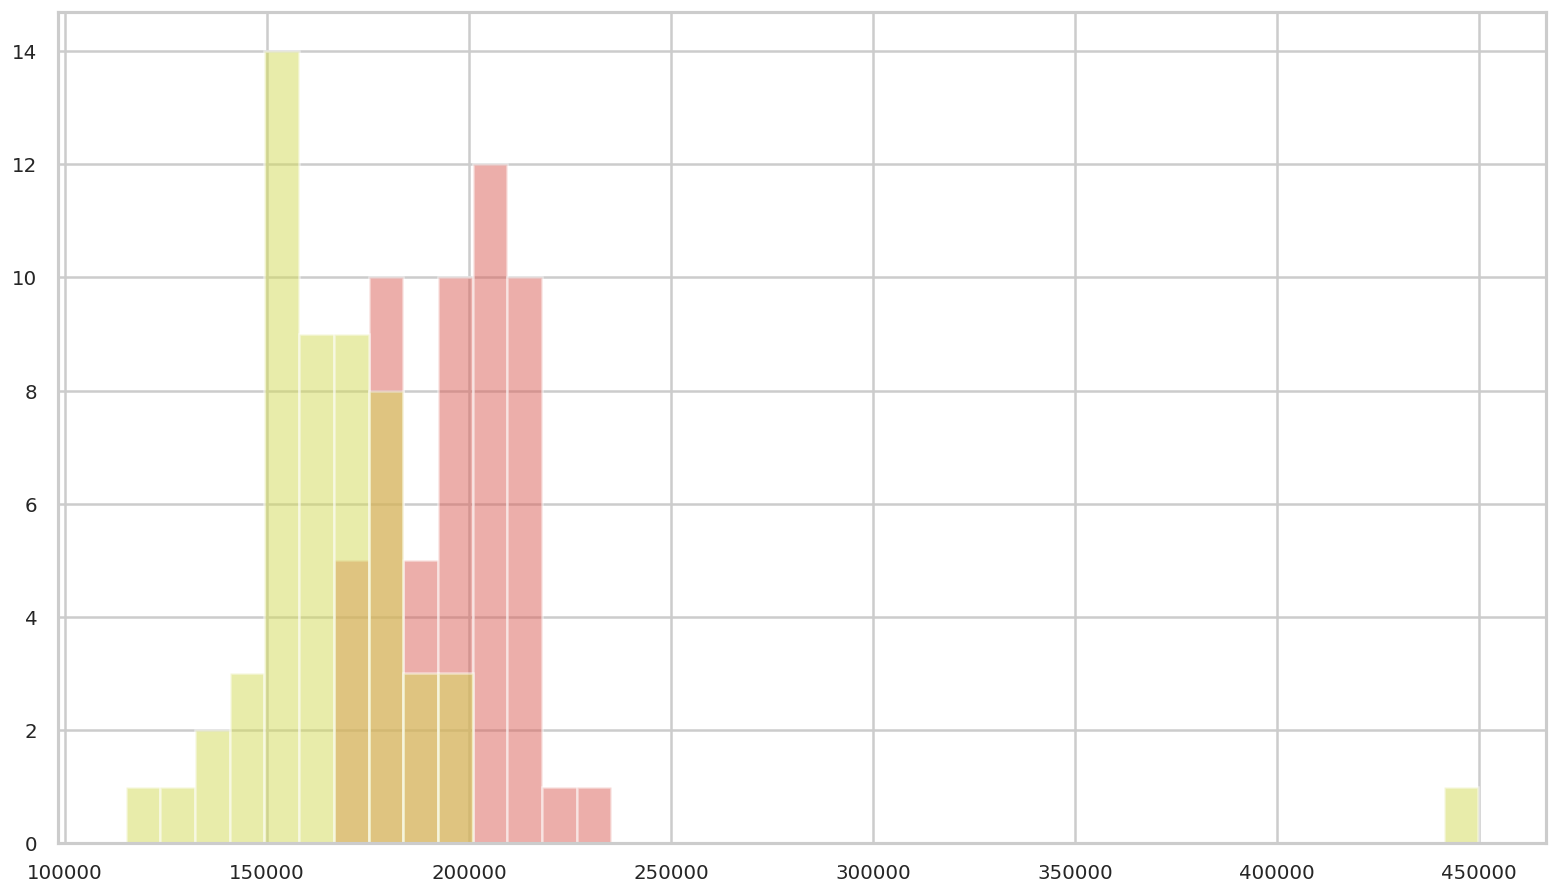

In [ ]:
bins = np.linspace(min(klUCBPlus_benchmark_results+MOSSExperimental_benchmark_results), max(klUCBPlus_benchmark_results+MOSSExperimental_benchmark_results), 40)
plt.hist(klUCBPlus_benchmark_results, bins,alpha=.5)
plt.hist(MOSSExperimental_benchmark_results, bins, alpha=.5)

In [ ]:
c = np.array([1,1,1,0,0])
d = np.array([0,0,1,1,1])
(c==1)==(d==1)

array([False, False,  True, False, False])

In [6]:
def pull_data(node):
    states = [node.state]
    num_arms = len(root_node.state[0].flatten())+1
    a = np.zeros(num_arms)
    a[node.legal_actions] = node.policy.rewards
    alphas = [a]
    p = np.zeros(num_arms)
    p[node.legal_actions] = node.policy.pulls
    betas = [p-a]
    for next_node in node.next_nodes.values():
        next_states, next_alphas, next_betas = pull_data(next_node)
        states += next_states
        alphas += next_alphas
        betas += next_betas
    return states, alphas, betas

In [17]:
writer = SummaryWriter()
env = go_v5.env(board_size = 3, komi = 3.5)
policy_algorithm=Policies.MOSSExperimental
env.reset(seed=42)
last = env.last()
root_node = GoNode(num_arms = last[0]['action_mask'].sum(), legal_actions = last[0]['action_mask'].nonzero()[0], policy_algorithm=policy_algorithm, state = last[0]['observation'].transpose((2,1,0)))
winner_list = []
big_number = 1e10
win_condition = 100
i = 0
using_network=False
states_per_training_batch = 150000
num_unique_states_visited = 1
# data collection and training loop
while True:
    # data collection and tree update loop
    while num_unique_states_visited < states_per_training_batch:
        print(num_unique_states_visited)
        node = root_node
        node_action_list = []
        observation, reward, termination, truncation, info = env.last()
        state = observation['observation'].transpose((2,1,0))
        mask = observation["action_mask"]
        # single game playout loop
        for agent in env.agent_iter():
            if termination or truncation:
                action = None
                winner = reward if agent=='black_0' else -reward
                winner = (winner + 1)/2
                winner_list.append(winner)
                writer.add_scalar('Winner', winner, str(i))
                break
            policy_choice = node.policy.choice()
            action = node.legal_actions[policy_choice]
            node_action_list.append((node,policy_choice))
            env.step(action)
            observation, reward, termination, truncation, info = env.last()
            state = observation['observation'].transpose((2,1,0))
            mask = observation["action_mask"]
            num_arms = np.count_nonzero(mask)
            if policy_choice in node.next_nodes:
                node = node.next_nodes[policy_choice]
            else:
                fictitious_alphas, fictitious_betas = network(state) if using_network else (None, None)
                node.next_nodes[policy_choice] = GoNode(num_arms=num_arms, 
                                                        legal_actions = mask.nonzero()[0], 
                                                        policy_algorithm=policy_algorithm if num_arms > 3 else Policies.klUCBPlus, 
                                                        player = 'white_0' if node.player=='black_0' else 'black_0', 
                                                        state=state,
                                                        fictitious_alphas = fictitious_alphas,
                                                        fictitious_betas = fictitious_betas)
                num_unique_states_visited += 1
                node = node.next_nodes[policy_choice]
        env.close()

        if {'black_0':1,'white_0':0}[node_action_list[-1][0].player] == winner:
            node_solved=-1
        else:
            node_solved=1
        # tree update loop
        for node, action in reversed(node_action_list):
            if node_solved !=0:
                node.policy.rewards[action] = big_number if node_solved==-1 else .5
                node.policy.pulls[action]=big_number
                # node.policy.pulls[action] +=1
            else:
                node.policy.getReward(action, (winner if node.player=='black_0' else 1-winner))
            node_solved = 1 if any(node.policy.rewards==big_number) else (-1 if (all(node.policy.rewards==.5) and all(node.policy.pulls==big_number)) else 0)
        
        # if len(winner_list)>win_condition and ((np.array(winner_list[-win_condition:])==1).all() or (np.array(winner_list[-win_condition:])==0).all()):
        #     break
        if any(root_node.policy.rewards==big_number):
            break
        env.reset(seed=42)

    states, target_alphas, target_betas = pull_data(root_node)
    if not using_network:
        network = Net()
        using_network = True
    network = train(network, states, target_alphas, target_betas)


1
12
28
44
71
87
96
119
129
137
160
169
177
183
225
249
265
280
295
307
320
325
332
346
353
360
369
383
391
411
423
428
435
443
452
478
483
502
516
527
537
548
553
569
580
590
606
614
626
637
654
663
671
681
682
688
694
707
718
730
752
772
788
793
801
817
823
836
863
912
924
931
944
1008
1017
1029
1048
1058
1070
1083
1104
1119
1143
1166
1178
1200
1212
1221
1253
1275
1283
1287
1309
1336
1355
1359
1363
1367
1374
1384
1398
1412
1426
1432
1441
1444
1452
1467
1475
1498
1506
1513
1520
1535
1545
1554
1562
1572
1582
1599
1609
1613
1631
1648
1656
1662
1674
1684
1697
1708
1719
1724
1735
1749
1777
1784
1793
1798
1825
1837
1847
1862
1871
1886
1896
1905
1915
1919
1932
1946
1953
1965
1980
1986
1995
2002
2017
2027
2036
2050
2056
2074
2090
2097
2099
2113
2120
2123
2139
2152
2167
2177
2179
2186
2206
2221
2231
2241
2243
2255
2275
2289
2304
2311
2320
2330
2344
2352
2377
2389
2422
2431
2454
2470
2476
2487
2495
2510
2520
2524
2533
2542
2548
2560
2576
2609
2624
2629
2636
2642
2657
2680
2685
2712
2720
2735
2

TypeError: Net.__init__() missing 1 required positional argument: 'type'

In [20]:
states, target_alphas, target_betas = pull_data(root_node)
target_alphas, target_betas = torch.FloatTensor(np.array(target_alphas)), torch.FloatTensor(np.array(target_betas))

In [21]:
target_alphas.size()

torch.Size([150007, 10])

In [22]:
states = torch.FloatTensor(np.array(states))
states.element_size()*states.nelement()

91804284

In [23]:
states.size()

torch.Size([150007, 17, 3, 3])

## Try different network architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Conv2d(17, 32, 3, 1, padding='same')] + \
            [nn.Conv2d(32, 32, 3, 1, padding='same') for i in range(2)] + \
            [nn.Conv2d(32, 2, 3, 1, padding='same')])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            x = F.relu(x)
        out = torch.flatten(self.layers[-1](x), -2, -1)
        passes = x[:,:2,:,:].mean(axis=(-1,-2))
        out = torch.cat((out, passes.unsqueeze(-1)), axis=-1)
        alphas = torch.exp(out[:,0,:])
        betas=torch.exp(out[:,1,:])
        return alphas, betas

In [12]:
root_node.next_nodes[0].policy.pulls

array([34., 58., 45., 60., 10.,  3.,  4., 19., inf])

## Loss function to choose + cross-validate loss and iterations and network architecture other inputs

In [29]:
class Net(nn.Module):
    def __init__(self, type):
        super(Net, self).__init__()
        if type == 1:
            self.layers = nn.ModuleList(
                [nn.Conv2d(17, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 2, 3, 1, padding='same')])
        elif type == 2:
            self.layers = nn.ModuleList(
                [nn.Conv2d(17, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 32, 3, 1, padding='same') for _ in range(2)] + \
                [nn.Conv2d(32, 2, 3, 1, padding='same')])
        elif type == 3:
            self.layers = nn.ModuleList(
                [nn.Conv2d(17, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 32, 3, 1, padding='same') for _ in range(4)] + \
                [nn.Conv2d(32, 2, 3, 1, padding='same')])
        elif type == 4:
            self.layers = nn.ModuleList(
                [nn.Conv2d(17, 64, 3, 1, padding='same')] + \
                [nn.Conv2d(64, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 16, 3, 1, padding='same')] + \
                [nn.Conv2d(16, 2, 3, 1, padding='same')])
        elif type == 5:
            self.layers = nn.ModuleList(
                [nn.Conv2d(17, 128, 3, 1, padding='same')] + \
                [nn.Conv2d(128, 64, 3, 1, padding='same')] + \
                [nn.Conv2d(64, 32, 3, 1, padding='same')] + \
                [nn.Conv2d(32, 16, 3, 1, padding='same')] + \
                [nn.Conv2d(16, 2, 3, 1, padding='same')])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            x = F.relu(x)
        out = torch.flatten(self.layers[-1](x), -2, -1)
        passes = x[:,:2,:,:].mean(axis=(-1,-2))
        out = torch.cat((out, passes.unsqueeze(-1)), axis=-1)
        alphas = torch.exp(out[:,0,:])
        betas=torch.exp(out[:,1,:])
        return alphas, betas
    
def augment(inpt, target_alphas, target_betas):
    rotation = random.randrange(4)
    flip = random.randrange(2)
    alpha_board_targets , alpha_pass_targets = torch.split(target_alphas, [9,1], dim=-1)
    beta_board_targets , beta_pass_targets = torch.split(target_betas, [9,1], dim=-1)
    alpha_board_targets_reshaped = alpha_board_targets.view(-1, int(np.sqrt(alpha_board_targets.shape[-1])),int(np.sqrt(alpha_board_targets.shape[-1])))
    beta_board_targets_reshaped = beta_board_targets.view(-1, int(np.sqrt(beta_board_targets.shape[-1])),int(np.sqrt(beta_board_targets.shape[-1])))
    inpt = torch.rot90(inpt,rotation,[-2,-1])
    alpha_board_targets_reshaped = torch.rot90(alpha_board_targets_reshaped,rotation,[-2,-1])
    beta_board_targets_reshaped = torch.rot90(beta_board_targets_reshaped,rotation,[-2,-1])
    if flip:
        inpt = torch.flip(inpt, [-1])
        alpha_board_targets_reshaped = torch.flip(alpha_board_targets_reshaped, [-1])
        beta_board_targets_reshaped = torch.flip(beta_board_targets_reshaped, [-1])
    alpha_board_targets = alpha_board_targets_reshaped.reshape(-1, alpha_board_targets.shape[-1])
    beta_board_targets = beta_board_targets_reshaped.reshape(-1, beta_board_targets.shape[-1])
    alpha_targets = torch.cat((alpha_board_targets, alpha_pass_targets),-1).contiguous()
    beta_targets = torch.cat((beta_board_targets, beta_pass_targets),-1).contiguous()
    return inpt, alpha_targets, beta_targets

def loss1(target_alpha_batches, p_hat, s):
    # return (target_beta_batches*p_hat**2 + target_alpha_batches*(1-p_hat)**2 + p_hat*(1-p_hat)/(s+1)*pulls).mean()
    return (target_alpha_batches - target_alpha_batches*p_hat + p_hat*(1-p_hat)/(s+1)).mean()

def loss2(p_hat, target_probs):
    return ((p_hat-target_probs)**2).mean()

def loss3(target_beta_batches, target_alpha_batches, p_hat):
    return (target_beta_batches*p_hat**2 + target_alpha_batches*(1-p_hat)**2).mean()

def loss4(target_alpha_batches, s, alphas):
    return (target_alpha_batches*(torch.digamma(s)-torch.digamma(alphas))).mean()

def tuning(network, loss_func):
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-5)

    batch_size = 64
    
    train_target_alphas, val_target_alphas, test_target_alphas = torch.split(target_alphas, [int(len(target_alphas)*0.7), int(len(target_alphas)*0.15), int(len(target_alphas)*0.15) + 1])
    train_target_betas, val_target_betas, test_target_betas = torch.split(target_betas, [int(len(target_betas)*0.7), int(len(target_betas)*0.15), int(len(target_betas)*0.15) + 1])
    train_states, val_states, test_states = torch.split(states, [int(len(states)*0.7), int(len(states)*0.15), int(len(states)*0.15) + 1])
    
    train_target_alpha_batches = torch.split(train_target_alphas, batch_size)
    train_target_beta_batches = torch.split(train_target_betas, batch_size)
    train_batches = torch.split(train_states, batch_size)
    ma = 0
        
    for epoch in range(10):
        print(f'epoch:{epoch}')
        for i in range(len(train_batches)):
            optimizer.zero_grad()
            aug_train_inpt, aug_train_target_alpha, aug_train_target_beta = augment(train_batches[i], train_target_alpha_batches[i], train_target_beta_batches[i])
            alphas, betas = network(aug_train_inpt)

            s = alphas+betas
            p_hat = alphas/s
            
            pulls = aug_train_target_alpha + aug_train_target_beta
            target_probs = aug_train_target_alpha/pulls
            target_probs[target_probs != target_probs] = 0

            if loss_func == loss1:
                train_loss = loss1(aug_train_target_alpha, p_hat, s)
            elif loss_func == loss2:
                train_loss = loss2(p_hat, target_probs)
            elif loss_func == loss3:
                train_loss = loss3(aug_train_target_beta, aug_train_target_alpha, p_hat)
            elif loss_func == loss4:
                train_loss = loss4(aug_train_target_alpha, s, alphas)
            train_loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print(train_loss.item())
    
    val_target_alpha_batches, val_target_beta_batches = torch.split(val_target_alphas, batch_size), torch.split(val_target_betas, batch_size)
    val_batches = torch.split(val_states, batch_size)
    val_batch_loss = []
    for i in range(len(val_batches)):
        optimizer.zero_grad()
        alphas, betas = network(val_batches[i])

        s = alphas+betas
        p_hat = alphas/s
        
        pulls = val_target_alpha_batches[i] + val_target_beta_batches[i]
        target_probs = val_target_alpha_batches[i]/pulls
        target_probs[target_probs != target_probs] = 0

        val_batch_loss += [loss1(val_target_alpha_batches[i], p_hat, s).item()]

    return val_batch_loss

In [30]:
val_losses = []
for architecture, loss_func in itertools.product(*[[Net(1), Net(2), Net(3), Net(4)],
                                     [loss1, loss2, loss3, loss4]]):
    val_losses.append(tuning(architecture, loss_func))

epoch:0
62037460.0
62341928.0
11782940.0
14663456.0
epoch:1
11499439.0
8645501.0
688081.625
2632958.5


KeyboardInterrupt: 

In [ ]:
best_i = 0
best_error = np.Inf
for i in range(len(val_losses)):
    if np.mean(val_losses[i]) < best_error:
        best_i = i
        best_error = np.mean(val_losses[i])
print(i)
print(best_error)

15
0.03682646167632673


In [41]:
import random

In [31]:
fake_target = torch.randn(64,10)

In [44]:
board_targets , pass_targets = torch.split(fake_target, [9,1], dim=-1)
board_targets_reshaped = board_targets.view(-1, int(np.sqrt(board_targets.shape[-1])),int(np.sqrt(board_targets.shape[-1])))

In [38]:
int(np.sqrt(board_targets.shape[-1]))

3

In [54]:
inpt = torch.zeros(64,17,3,3)
inpt[0,0,0,0]=1
targets = torch.zeros(64,10)
targets[0,0]=1

In [75]:
augment(inpt, targets)

torch.Size([64, 9])
torch.Size([64, 3, 3])


(tensor([[[[0., 0., 1.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],

In [55]:
targets

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [ ]:
torch.split(a,64)[0].shape

torch.Size([64, 17, 4, 4])

In [ ]:
network(torch.FloatTensor(root_node.next_nodes[4].state).unsqueeze(0))

(tensor([[6.8608e+02, 1.6832e+04, 1.1194e+03, 1.9181e+04, 2.7628e+06, 5.2306e+04,
          1.6109e+03, 5.7940e+04, 3.1252e+03, 1.1940e+03]],
        grad_fn=<ExpBackward0>),
 tensor([[1.6154e-03, 7.8157e-05, 1.2027e-03, 5.5434e-05, 9.1532e-07, 9.0809e-05,
          8.8335e-04, 6.4726e-05, 2.0962e-03, 1.0000e+00]],
        grad_fn=<ExpBackward0>))

In [ ]:
root_node.next_nodes[4].state

array([[[ True, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, Fal